In [537]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import spacy
import string
import random
import pickle as pkl
import time 
import os
from os import listdir 
from collections import Counter
from tqdm import tqdm_notebook
from functools import partial 
import nltk
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim import SGD 
from torch.optim import RMSprop
from torch.optim import lr_scheduler 
from ast import literal_eval
from datetime import datetime
pd.set_option('max_colwidth',100)

# Import and Process Data 

In [2]:
# helper methods to load reviews from directories 

def load_single_review(fdir, fname): 
    """ Takes as input file directory and file name of a single review, returns review as string """
    fpath = fdir + '/' + fname 
    with open(fpath, 'r') as f: 
        review = f.read()
        return review 
    
def load_dir_reviews(fdir): 
    """ Takes as input file directory where reviews are stored, returns them as a list of review strings """
    fnames = [f for f in listdir(fdir)]
    reviews = [load_single_review(fdir, fname) for fname in fnames]
    return reviews

def combine_data(neg_reviews, pos_reviews): 
    """ Combines lists of negative and positive reviews, returns a combined dataset comprising reviews and labels """
    neg_with_labels = [(review, 0) for review in neg_reviews] 
    pos_with_labels = [(review, 1) for review in pos_reviews]
    combined = neg_with_labels + pos_with_labels
    combined = random.sample(combined, len(combined))
    reviews = [comb[0] for comb in combined]
    labels = [comb[1] for comb in combined]
    return reviews, labels 

In [3]:
# load reviews into lists 
train_val_neg = load_dir_reviews('aclImdb/train/neg')
train_val_pos = load_dir_reviews('aclImdb/train/pos')
test_neg = load_dir_reviews('aclImdb/test/neg')
test_pos = load_dir_reviews('aclImdb/test/pos')

In [4]:
# randomly split train into train vs. validation sets 
train_split = int(20000 / 2) 
train_neg = train_val_neg[:train_split]
train_pos = train_val_pos[:train_split]
val_neg = train_val_neg[train_split:]
val_pos = train_val_pos[train_split:]

In [5]:
# combine pos and neg reviews to get unified datasets 
train_data, train_labels = combine_data(train_neg, train_pos)
val_data, val_labels = combine_data(val_neg, val_pos)
test_data, test_labels = combine_data(test_neg, test_pos)
print ("Train dataset size is {}".format(len(train_data)))
print ("Validation dataset size is {}".format(len(val_data)))
print ("Test dataset size is {}".format(len(test_data)))

Train dataset size is 20000
Validation dataset size is 5000
Test dataset size is 25000


In [251]:
# put various optimization algorithms in a dictionary for ease of recording results + running experiments
optim_algos = {'Adam': Adam, 'SGD': SGD, 'RMSprop': RMSprop}

# Tokenization

In [266]:
# helper functions to tokenize reviews 

tokenizer = spacy.load('en_core_web_sm')

def lower_case(parsed):
    """ Takes text as input and outputs a list of tokens in lowercase without punctuation """
    return [token.text.lower() for token in parsed]

def tokenize_dataset(dataset, processing_func):
    """ Takes as input a dataset comprising a list of reviews, outputs the tokenized dataset along with 
        a list comprising all the tokens from the dataset """
    token_dataset = []
    for sample in tqdm_notebook(tokenizer.pipe(dataset, 
                                               disable=['parser', 'tagger', 'ner'], batch_size=512, n_threads=1)):
        tokens = processing_func(sample)
        token_dataset.append(tokens)
    return token_dataset

def save_to_pickle(item_to_save, filename): 
    if not os.path.exists(os.path.dirname(filename)):
        os.makedirs(os.path.dirname(filename))
    with open(filename, "wb") as f: 
        pkl.dump(item_to_save, f)
    
def tokenize_dataset_to_disk(dataset, processing_func, filename): 
    """ Tokenize dataset as save as pickle to destination path """
    start_time = time.time() 
    token_dataset = tokenize_dataset(dataset, processing_func)
    save_to_pickle(token_dataset, filename)
    time_elapsed = (time.time() - start_time) / 60.0 
    print("Data tokenized and saved as {} in {:.1f} minutes".format(filename, time_elapsed))
    return token_dataset
    
def tokenize_datasets_to_disk(train_data, val_data, test_data, processing_func, folder_name): 
    """ Tokenizes train, val, test datasets and save as pickle to data subfolder 
        Also returns tokenized datasets
    """
    train_data_tokens = tokenize_dataset_to_disk(train_data, processing_func, 
                                                 "data/{}/train_data_tokens.p".format(folder_name))
    val_data_tokens = tokenize_dataset_to_disk(val_data, processing_func, 
                                               "data/{}/val_data_tokens.p".format(folder_name))    
    test_data_tokens = tokenize_dataset_to_disk(test_data, processing_func, 
                                                "data/{}/test_data_tokens.p".format(folder_name))
    return train_data_tokens, val_data_tokens, test_data_tokens

def load_tokens_from_disk(folder_name): 
    """ Loads train/val/test tokens from disk for a given set of tokenization scheme, denoted by folder name"""
    train_data_tokens = pkl.load(open("data/{}/train_data_tokens.p".format(folder_name), "rb"))
    val_data_tokens = pkl.load(open("data/{}/val_data_tokens.p".format(folder_name), "rb"))
    test_data_tokens = pkl.load(open("data/{}/test_data_tokens.p".format(folder_name), "rb"))
    return train_data_tokens, val_data_tokens, test_data_tokens

In [153]:
train_data_tokens, val_data_tokens, test_data_tokens = tokenize_datasets_to_disk(
    train_data, val_data, test_data, processing_func=lower_case, folder_name='lowercase')


Data tokenized and saved as data/lowercase/train_data_tokens.p in 0.7 minutes



Data tokenized and saved as data/lowercase/val_data_tokens.p in 0.2 minutes



Data tokenized and saved as data/lowercase/test_data_tokens.p in 0.8 minutes


In [521]:
# load saved tokens 
train_data_tokens, val_data_tokens, test_data_tokens = load_tokens_from_disk(folder_name='lowercase')
all_train_tokens = [item for sublist in train_data_tokens for item in sublist] 

# double check 
print ("Train dataset size is {}".format(len(train_data_tokens)))
print ("Val dataset size is {}".format(len(val_data_tokens)))
print ("Test dataset size is {}".format(len(test_data_tokens)))
print ("Total number of tokens in train dataset is {}".format(len(all_train_tokens)))

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000
Total number of tokens in train dataset is 5439615


In [522]:
# create vocabulary from 10000 most common tokens in the training set 

PAD_IDX=0
UNK_IDX=1

def build_vocab(all_tokens, max_vocab_size=10000, pad_idx=PAD_IDX, unk_idx=UNK_IDX): 
    """ Takes list of all tokens and returns:
        - id2token: list of tokens, where id2token[i] returns token that corresponds to i-th token 
        - token2id: dictionary where keys represent tokens and corresponding values represent their indices
    """
    token_counter = Counter(all_tokens)
    vocab, count = zip(*token_counter.most_common(max_vocab_size))
    id2token = list(vocab)
    token2id = dict(zip(vocab, range(2, 2+len(vocab))))
    id2token = ['<pad>', '<unk>'] + id2token 
    token2id['<pad>'] = pad_idx
    token2id['<unk>'] = unk_idx
    return token2id, id2token 
    
token2id, id2token = build_vocab(all_train_tokens, max_vocab_size = 10000)

In [523]:
# check the dictionary by loading random token from it

random_token_id = random.randint(0, len(id2token)-1)
random_token = id2token[random_token_id]

print ("Token id {} ; token {}".format(random_token_id, id2token[random_token_id]))
print ("Token {}; token id {}".format(random_token, token2id[random_token]))

Token id 9637 ; token finch
Token finch; token id 9637


In [524]:
# convert token to id in the dataset 

def token2index_dataset(tokens_data, token2id, unk_idx=UNK_IDX): 
    """ Converts data from word tokens to token indices """
    indices_data = []
    for datum in tokens_data: 
        index_list = [token2id[token] if token in token2id else unk_idx for token in datum]
        indices_data.append(index_list)
    return indices_data 

train_data_indices = token2index_dataset(train_data_tokens, token2id)
val_data_indices = token2index_dataset(val_data_tokens, token2id)
test_data_indices = token2index_dataset(test_data_tokens, token2id)

In [525]:
# check size of data 
print ("Train dataset size is {}".format(len(train_data_indices)))
print ("Val dataset size is {}".format(len(val_data_indices)))
print ("Test dataset size is {}".format(len(test_data_indices)))

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000


In [526]:
# check tokenization of dataset 
print(train_data_tokens[0])
print(train_data_indices[0])

['series', 'three-', 'blackadder', 'the', 'third', '"', 'if', 'you', 'want', 'something', 'done', 'properly', ',', 'kill', 'baldrick', 'before', 'you', 'start', '"', 'hot', 'on', 'the', 'heels', 'of', 'the', 'second', 'series', 'the', 'show', 'returned', 'with', 'the', 'current', 'owner', 'of', 'the', 'famous', 'name', 'down', 'on', 'his', 'luck', 'and', 'in', 'service', 'as', 'butler', 'to', 'the', 'prince', 'regent', ',', 'a', 'vain', 'and', 'stupid', 'foil', 'for', 'blackadders', 'venom', ',', 'played', 'by', 'hugh', 'laurie', '.', 'baldrick', 'is', 'still', 'in', 'tow', 'as', 'the', 'other', 'piece', 'of', 'the', 'comedic', 'jigsaw', '.', 'the', 'format', 'is', 'similar', 'to', 'the', 'previous', 'show', ',', 'after', 'all', 'now', 'they', 'had', 'found', 'the', 'winning', 'formula', 'why', 'change', 'things', '.', 'we', 'see', 'blackadder', 'trying', 'to', 'get', 'rich', 'off', 'of', 'the', 'back', 'of', 'the', 'gullible', 'regent', 'in', 'many', 'more', 'ingenious', 'ways', ',', 

# Model Architecture and Data Loader

In [527]:
# define custom dataset class and collate function for data loader 

class MovieReviewsDataset(Dataset): 
    """ 
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list, label_list, max_sentence_length): 
        """ 
        Initialize dataset by passing in a list of movie review tokens and a list of labels 
        """
        self.data_list = data_list 
        self.label_list = label_list 
        self.max_sentence_length = max_sentence_length
        assert (len(self.data_list) == len(self.label_list))
        
    def __len__(self): 
        return len(self.data_list)
    
    def __getitem__(self, key): 
        """
        Triggered when dataset[i] is called, outputs a list of tokens, length of list, and label of the data point
        """
        token_idx = self.data_list[key][:self.max_sentence_length]
        label = self.label_list[key]
        return [token_idx, len(token_idx), label]
    
def collate_func(max_sentence_length, batch): 
    """ 
    Customized function for DataLoader that dynamically pads the batch so that the data have the same length
    Note that this takes max_sentence_length as a first argument to be prefilled with a partial function later 
        to facilitate hyperparameter tuning 
    """
    data_list = [] 
    label_list = [] 
    length_list = [] 
    
    for datum in batch:         
        label_list.append(datum[2])
        length_list.append(datum[1])
        # pad data before appending 
        padded_vec = np.pad(array = np.array(datum[0]), 
                            pad_width = ((0, max_sentence_length - datum[1])), 
                            mode = 'constant', constant_values = 0)
        data_list.append(padded_vec)
        
    return [torch.from_numpy(np.array(data_list)), torch.LongTensor(length_list), torch.LongTensor(label_list)]

In [528]:
# define model architecture and helper methods 

class BagOfWords(nn.Module): 
    """ 
    BagOfWords classification model 
    """
    
    def __init__(self, vocab_size, emb_dim): 
        """ 
        @param vocab_size: size of the vocabulary 
        @param emd_dim: size of the word embedding 
        """
        super().__init__() 
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.linear = nn.Linear(emb_dim, 2)
        
    def forward(self, data, length): 
        """ 
        @param data: matrix of size (batch_size, max_sentence_length). Each row in data represents a review
            that is represented using n-gram index. Note that they are padded to have the same length. 
        @param length: an int tensor of size (batch_size), which represents the non-trivial (i.e. non-padded)
            length of each sentence in the data 
        """
        out = self.embed(data)
        out = torch.sum(out, dim=1)
        out /= length.view(length.size()[0],1).expand_as(out).float()
        
        # return logits
        out = self.linear(out.float())

        return out

# Model Training and Evaluation

In [529]:
# helper functions to train and test model 

def test_model(loader, model): 
    """ 
    Helper function that tests the model's performance on a given dataset 
    @param: loader = data loader for the dataset to test against 
    """
    correct = 0 
    total = 0 
    model.eval() 
    
    for data_batch, length_batch, label_batch in loader: 
        outputs = F.softmax(model(data_batch, length_batch), dim=1)
        predictions = outputs.max(1, keepdim=True)[1]    
        total += label_batch.size(0)
        correct += predictions.eq(label_batch.view_as(predictions)).sum().item()
        
    return (100 * correct / total)

In [659]:
# def train_and_eval(model, optimizer, train_loader, val_loader, num_epochs, print_intermediate=True):  
#     """
#     Trains model on data from train_loader and evaluates on data from val_loader for num_epochs 
#     Returns results as a dictionary comprising epoch, train accuracy, and validation accuracy 
#     """
#     # train and validate 
#     criterion = torch.nn.CrossEntropyLoss()
#     results = []
#     for epoch in range(num_epochs):
#         for i, (data_batch, length_batch, label_batch) in enumerate(train_loader):
#             model.train()
#             optimizer.zero_grad()
#             outputs = model(data_batch, length_batch)
#             loss = criterion(outputs, label_batch)
#             loss.backward()
#             optimizer.step()
#             # validate every 100 iterations
#             if i % 100 == 0 or ((epoch==num_epochs-1) & (i==len(train_loader)-1)):
#                 result = {} 
#                 result['epoch'] = epoch + i / len(train_loader)
#                 result['train_acc'] = test_model(train_loader, model)
#                 result['val_acc'] = test_model(val_loader, model)       
#                 results.append(result)

#                 if print_intermediate: 
#                     print('Epoch: {:.2f}, Train Accuracy: {:.2f}%, Validation Accuracy: {:.2f}%'.format(
#                         result['epoch'], result['train_acc'], result['val_acc']))
    
#     return results 

def train_and_eval(model, optimizer, scheduler, train_loader, val_loader, 
                   num_epochs, print_intermediate=True):  
    """
    Trains model on data from train_loader and evaluates on data from val_loader for num_epochs 
    Returns results as a dictionary comprising epoch, train accuracy, and validation accuracy 
    """
    # train and validate 
    criterion = torch.nn.CrossEntropyLoss()
    
    results = []
    for epoch in range(num_epochs):
        for i, (data_batch, length_batch, label_batch) in enumerate(train_loader):
            model.train()
            optimizer.zero_grad()
            outputs = model(data_batch, length_batch)
            loss = criterion(outputs, label_batch)
            loss.backward()
            optimizer.step()
            # validate every 100 iterations
            if i % 100 == 0 or ((epoch==num_epochs-1) & (i==len(train_loader)-1)):
                result = {} 
                result['epoch'] = epoch + i / len(train_loader)
                result['train_acc'] = test_model(train_loader, model)
                result['val_acc'] = test_model(val_loader, model)       
                results.append(result)

                if print_intermediate: 
                    print('Epoch: {:.2f}, Train Accuracy: {:.2f}%, Validation Accuracy: {:.2f}%'.format(
                        result['epoch'], result['train_acc'], result['val_acc']))
        scheduler.step()
    return results 

In [660]:
# helper functions to save results to and load results from a pkl logfile 

RESULTS_LOG = 'experiment_results/experiment_results_log_v2.pkl'

def append_to_log(hyperparams, results, runtime, experiment_name, filename=RESULTS_LOG): 
    """ Appends results and details of a single experiment to a log file """
    
    # create directory if doesn't already exist 
    if not os.path.exists(os.path.dirname(filename)):
        os.makedirs(os.path.dirname(filename))
        
    # store experiment details in a dictionary 
    new_result = {'experiment_name': experiment_name, 'hyperparams': hyperparams, 'results': results, 
                  'runtime': runtime, 'dt_created': datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
    
    # if log already exists, append to log 
    try: 
        results_log = pkl.load(open(filename, "rb"))
        results_log.append(new_result)

    # if log doesn't exists, initialize first result as the log 
    except (OSError, IOError) as e:
        results_log = [new_result]
    
    # save to pickle 
    pkl.dump(results_log, open(filename, "wb"))

In [661]:
def load_experiment_log(experiment_name=None, filename=RESULTS_LOG): 
    """ Loads experiment log, with option to filter for a specific experiment_name """
    
    results_log = pkl.load(open(filename, "rb"))
    
    if experiment_name is not None: 
        results_log = [r for r in results_log if r['experiment_name'] == experiment_name]
        
    return results_log 

In [672]:
def run_experiment(train_tokens, val_tokens, train_labels, val_labels, max_sentence_length, 
                   max_vocab_size, emb_dim, optim_algo, learning_rate, num_epochs, 
                   lr_annealing = 'None', batch_size=32, experiment_name='Not Specified', 
                   token_scheme='Default', max_ngram='Default',
                   save_to_log=True, print_summary=True, print_intermediate=True):  
    
    """ Wraps all processing, training and evaluation steps in a function to facilitate hyperparam tuning. 
        Note that the function takes as input tokenized data rather than raw data since there's significant 
        lag time in generating tokens.  
    """
    
    start_time = time.time() 
    
    # build vocab based on max_vocab_size specified 
    all_train_tokens = [item for sublist in train_data_tokens for item in sublist] 
    token2id, id2token = build_vocab(all_train_tokens, max_vocab_size)
    
    # convert tokens to token indices 
    train_data_indices = token2index_dataset(train_data_tokens, token2id)
    val_data_indices = token2index_dataset(val_data_tokens, token2id)
    
    # instantiate PyTorch Dataset object 
    train_dataset = MovieReviewsDataset(train_data_indices, train_labels, max_sentence_length)
    val_dataset = MovieReviewsDataset(val_data_indices, val_labels, max_sentence_length)
    
    # create PyTorch DataLoader
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, 
                                               collate_fn=partial(collate_func, max_sentence_length))
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True, 
                                             collate_fn=partial(collate_func, max_sentence_length))
    
    # instantiate model and optimizer 
    model = BagOfWords(len(token2id), emb_dim)
    optimizer = optim_algos[optim_algo](params=model.parameters(), lr=learning_rate) 
    scheduler = lr_scheduler.StepLR(optimizer, 
                                    step_size=lr_adj_schedules[lr_annealing]['lr_adj_step'], 
                                    gamma=lr_adj_schedules[lr_annealing]['lr_adj_gamma'])
    
    # train and evaluate 
    results = train_and_eval(model, optimizer, scheduler, train_loader, val_loader, num_epochs, print_intermediate)
    
    # store, print, and save results 
    runtime = time.time() - start_time 
    hyperparams = {'token_scheme': token_scheme, 'max_ngram': max_ngram, 
                   'max_sentence_length': max_sentence_length, 'max_vocab_size': max_vocab_size, 
                   'emb_dim': emb_dim, 'optim_algo': optim_algo, 'learning_rate': learning_rate, 
                   'lr_annealing': lr_annealing, 'num_epochs': num_epochs}
    if save_to_log: 
        append_to_log(hyperparams, results, runtime, experiment_name)
    if print_summary: 
        print("Experiment completed in {} seconds with {}% validation accuracy.".format(
            int(runtime), pd.DataFrame.from_dict(results)['val_acc'].max()))
        
    return results, hyperparams, runtime

In [663]:
# helper methods to summarize, evaluate, and plot results 

def summarize_results(results_log): 
    """ Summarizes results_log (list) into a dataframe, splitting hyperparameters string into columns, and reducing 
        the val_acc dict into the best validation accuracy obtained amongst all the epochs logged """
    results_df = pd.DataFrame.from_dict(results_log)
    results_df = pd.concat([results_df, results_df['hyperparams'].apply(pd.Series)], axis=1)
    results_df['val_acc'] = results_df['results'].apply(lambda d: pd.DataFrame.from_dict(d)['val_acc'].max())
    output_cols = ['experiment_name', 'token_scheme', 'max_ngram', 'max_sentence_length', 
                   'max_vocab_size', 'emb_dim', 'optim_algo', 'learning_rate', 'lr_annealing', 
                   'num_epochs', 'runtime', 'val_acc', 'results']
    return results_df[output_cols].sort_values(by='val_acc', ascending=False) 

def plot_multiple_learning_curves(results_df, plot_variable, figsize=(8, 5), legend_loc='best'):
    """ Plots learning curves of MULTIPLE experiments, includes only validation accuracy """
    plt.figure(figsize=figsize)
    for index, row in results_df.iterrows():
        val_acc_hist = pd.DataFrame.from_dict(row['results']).set_index('epoch')['val_acc'] 
        plt.plot(val_acc_hist, label="{} ({}%)".format(row[plot_variable], val_acc_hist.max()))
    plt.ylabel('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.legend(title=plot_variable, loc=legend_loc)    
    
def plot_single_learning_curve(results): 
    """ Plots learning curve of a SINGLE experiment, includes both train and validation accuracy """
    results_df = pd.DataFrame.from_dict(results)
    results_df = results_df.set_index('epoch')
    results_df.plot()
    plt.ylabel('Validation Accuracy')
    plt.xlabel('Epoch')

## Basic Model  

First let's train and evaluate a basic model with a set of arbitrary hyperparameters to make sure the code runs correctly:

In [590]:
results, hyperparams, runtime = run_experiment(
    train_data_tokens, val_data_tokens, train_labels, val_labels, max_sentence_length=200, 
    max_vocab_size=10000, emb_dim=100, optim_algo='Adam', learning_rate=0.01, num_epochs=2) 

Epoch: 0.00, Train Accuracy: 49.98%, Validation Accuracy: 50.00%
Epoch: 0.16, Train Accuracy: 81.09%, Validation Accuracy: 78.58%
Epoch: 0.32, Train Accuracy: 86.19%, Validation Accuracy: 82.20%
Epoch: 0.48, Train Accuracy: 88.88%, Validation Accuracy: 82.82%
Epoch: 0.64, Train Accuracy: 89.20%, Validation Accuracy: 82.42%
Epoch: 0.80, Train Accuracy: 91.37%, Validation Accuracy: 83.86%
Epoch: 0.96, Train Accuracy: 92.08%, Validation Accuracy: 84.18%
Epoch: 1.00, Train Accuracy: 92.78%, Validation Accuracy: 83.66%
Epoch: 1.16, Train Accuracy: 92.79%, Validation Accuracy: 83.94%
Epoch: 1.32, Train Accuracy: 92.63%, Validation Accuracy: 83.70%
Epoch: 1.48, Train Accuracy: 93.78%, Validation Accuracy: 82.30%
Epoch: 1.64, Train Accuracy: 93.56%, Validation Accuracy: 83.04%
Epoch: 1.80, Train Accuracy: 94.97%, Validation Accuracy: 82.92%
Epoch: 1.96, Train Accuracy: 95.31%, Validation Accuracy: 83.16%
Epoch: 2.00, Train Accuracy: 95.28%, Validation Accuracy: 82.62%
Experiment completed in 8

It looks like we were able to obtain pretty good results already: ~84% accuracy on unseen validation dataset. We will proceed to try different proprocessing and hyperparameters next. 

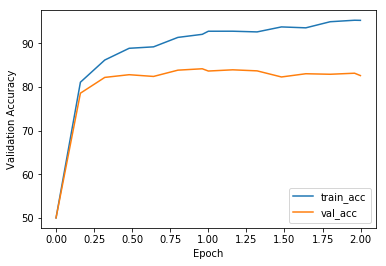

In [591]:
# learning curve 
plot_single_learning_curve(results)

## Model Tuning 

#### Tokenization Schemes

Previously we converted our text data to tokens with limited preprocessing: the standard SpaCy tokenizer was applied on the lowercased text. In this section, we experiment with other tokenization schemes: 

0. Lowercased Text ("Standard") 
1. Lowercased Text + Removed Punctuation 
2. Lowercased Text + Removed Punctuation + Removed Stopwards (SpaCy)
3. Lowercased Text + Removed Punctuation + Removed Stopwards (NLTK)
4. Lowercased Text + Removed Punctuation + Removed Stopwards (SpaCy) + Lemmatize 
5. Lowercased Text + Removed Punctuation + Removed Stopwards (NLTK) + Lemmatize 

In [261]:
punctuations = string.punctuation 
spacy_stop_words = tokenizer.Defaults.stop_words
nltk_stop_words = nltk.corpus.stopwords.words('english')

Note that we are testing two sets of stopwords, one from SpaCy and another from NLTK. SpaCy's considerably longer, and includes a number of words that might be important in n-grams, e.g. 'not', 'very'. NLTK's is shorter and appears to be more conservative. 

In [262]:
print(spacy_stop_words)

{'would', 'first', 'latterly', 'under', 'before', 'why', 'through', 'has', 'onto', 'give', 'via', 'into', 'thereafter', 'they', 'wherein', 'nevertheless', 'becoming', 'i', 'nowhere', 'or', 'anything', 'really', 'whole', 'front', 'nobody', 'within', 'often', 'still', 'not', 'becomes', 'next', 'much', 'might', 'none', 'the', 'anywhere', 'with', 'former', 'may', 'its', 'another', 'their', 'while', 'noone', 'across', 'thereby', 'up', 'because', 'empty', 'than', 'ten', 'meanwhile', 'therein', 'three', 'whenever', 'whether', 'fifty', 'afterwards', 'had', 'used', 'nothing', 'although', 'per', 'amount', 'thus', 'at', 'over', 'besides', 'my', 'already', 'whence', 'against', 'thereupon', 'each', 'whoever', 'whom', 'hereby', 'name', 'seeming', 'thence', 'fifteen', 'him', 'only', 'some', 'could', 'which', 'call', 'hereafter', 'neither', 'somewhere', 'being', 'take', 'yours', 'between', 'more', 'five', 'too', 'perhaps', 'formerly', 'beforehand', 'doing', 'many', 'otherwise', 'part', 'and', 'now', '

In [263]:
print(nltk_stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'no

In [264]:
# define various tokenization functions and store as a dictionary 

def remove_punc(parsed):
    """ Takes text as input and outputs a list of tokens in lowercase without punctuation """
    return [token.text.lower() for token in parsed if (token.text not in punctuations)]

def remove_punc_spacy_stopwords(parsed):
    """ Takes text as input and outputs a list of tokens in lowercase without punctuation """
    return [token.text.lower() for token in parsed 
            if (token.text not in punctuations and token.text.lower() not in spacy_stop_words)]

def remove_punc_nltk_stopwords(parsed):
    """ Takes text as input and outputs a list of tokens in lowercase without punctuation """
    return [token.text.lower() for token in parsed 
            if (token.text not in punctuations and token.text.lower() not in nltk_stop_words)]

def remove_punc_spacy_stopwords_lemmatize(parsed):
    """ Takes text as input and outputs a list of tokens in lowercase without punctuation """
    return [token.lemma_.lower() for token in parsed 
            if (token.text not in punctuations and token.lemma_.lower() not in spacy_stop_words)]

def remove_punc_nltk_stopwords_lemmatize(parsed):
    """ Takes text as input and outputs a list of tokens in lowercase without punctuation """
    return [token.lemma_.lower() for token in parsed 
            if (token.text not in punctuations and token.lemma_.lower() not in nltk_stop_words)]

tokenization_schemes = {'lowercase': lower_case, 
                        'lowercase_no_punc': remove_punc, 
                        'lowercase_no_punc_stopwords_spacy': remove_punc_spacy_stopwords, 
                        'lowercase_no_punc_stopwords_nltk': remove_punc_nltk_stopwords, 
                        'lowercase_no_punc_stopwords_spacy_lemmatize': remove_punc_spacy_stopwords_lemmatize, 
                        'lowercase_no_punc_stopwords_nltk_lemmatize': remove_punc_nltk_stopwords_lemmatize}

In [53]:
# run various tokenization experiments and save down as tokens 

for t_scheme in tokenization_schemes:     
    print ("Tokenizing with scheme: {} ...".format(t_scheme))
    _, _, _ = tokenize_datasets_to_disk(train_data, val_data, test_data, 
                                        processing_func=tokenization_schemes[t_scheme], folder_name=t_scheme)

Tokenizing with scheme: lowercase ...



Data tokenized and saved as data/lowercase/train_data_tokens.p in 0.7 minutes



Data tokenized and saved as data/lowercase/val_data_tokens.p in 0.1 minutes



Data tokenized and saved as data/lowercase/test_data_tokens.p in 0.7 minutes
Tokenizing with scheme: lowercase_no_punc ...



Data tokenized and saved as data/lowercase_no_punc/train_data_tokens.p in 0.6 minutes



Data tokenized and saved as data/lowercase_no_punc/val_data_tokens.p in 0.1 minutes



Data tokenized and saved as data/lowercase_no_punc/test_data_tokens.p in 0.7 minutes
Tokenizing with scheme: lowercase_no_punc_stopwords_spacy ...



Data tokenized and saved as data/lowercase_no_punc_stopwords_spacy/train_data_tokens.p in 0.6 minutes



Data tokenized and saved as data/lowercase_no_punc_stopwords_spacy/val_data_tokens.p in 0.1 minutes



Data tokenized and saved as data/lowercase_no_punc_stopwords_spacy/test_data_tokens.p in 0.7 minutes
Tokenizing with scheme: lowercase_no_punc_stopwords_nltk ...



Data tokenized and saved as data/lowercase_no_punc_stopwords_nltk/train_data_tokens.p in 0.7 minutes



Data tokenized and saved as data/lowercase_no_punc_stopwords_nltk/val_data_tokens.p in 0.2 minutes



Data tokenized and saved as data/lowercase_no_punc_stopwords_nltk/test_data_tokens.p in 0.8 minutes
Tokenizing with scheme: lowercase_no_punc_stopwords_spacy_lemmatize ...



Data tokenized and saved as data/lowercase_no_punc_stopwords_spacy_lemmatize/train_data_tokens.p in 0.6 minutes



Data tokenized and saved as data/lowercase_no_punc_stopwords_spacy_lemmatize/val_data_tokens.p in 0.2 minutes



Data tokenized and saved as data/lowercase_no_punc_stopwords_spacy_lemmatize/test_data_tokens.p in 0.8 minutes
Tokenizing with scheme: lowercase_no_punc_stopwords_nltk_lemmatize ...



Data tokenized and saved as data/lowercase_no_punc_stopwords_nltk_lemmatize/train_data_tokens.p in 0.8 minutes



Data tokenized and saved as data/lowercase_no_punc_stopwords_nltk_lemmatize/val_data_tokens.p in 0.2 minutes



Data tokenized and saved as data/lowercase_no_punc_stopwords_nltk_lemmatize/test_data_tokens.p in 1.1 minutes


In [430]:
# run tokenization experiments 

for t_scheme in tokenization_schemes: 
    
    print ("Training with {} tokenization scheme...".format(t_scheme))
    
    # load tokens from disk 
    train_data_tokens, val_data_tokens, test_data_tokens = load_tokens_from_disk(folder_name=t_scheme)
    
    # train and evaluate
    results, hyperparams, runtime = run_experiment(
        train_data_tokens, val_data_tokens, train_labels, val_labels, max_sentence_length=200, max_vocab_size=10000, 
        emb_dim=100, optim_algo='Adam', learning_rate=0.001, num_epochs=5, batch_size=32, token_scheme=t_scheme, 
        experiment_name='Tokenization_5_epoch', save_to_log=True, print_summary=True, print_intermediate=True) 

Training with lowercase tokenization scheme...
Epoch: 0.00, Train Accuracy: 47.77%, Validation Accuracy: 45.60%
Epoch: 0.16, Train Accuracy: 59.95%, Validation Accuracy: 59.00%
Epoch: 0.32, Train Accuracy: 67.93%, Validation Accuracy: 64.72%
Epoch: 0.48, Train Accuracy: 71.78%, Validation Accuracy: 70.50%
Epoch: 0.64, Train Accuracy: 75.00%, Validation Accuracy: 72.60%
Epoch: 0.80, Train Accuracy: 77.39%, Validation Accuracy: 74.54%
Epoch: 0.96, Train Accuracy: 78.97%, Validation Accuracy: 76.60%
Epoch: 1.00, Train Accuracy: 79.98%, Validation Accuracy: 77.04%
Epoch: 1.16, Train Accuracy: 81.31%, Validation Accuracy: 78.28%
Epoch: 1.32, Train Accuracy: 82.77%, Validation Accuracy: 79.22%
Epoch: 1.48, Train Accuracy: 83.64%, Validation Accuracy: 80.22%
Epoch: 1.64, Train Accuracy: 84.61%, Validation Accuracy: 80.66%
Epoch: 1.80, Train Accuracy: 85.08%, Validation Accuracy: 81.08%
Epoch: 1.96, Train Accuracy: 85.92%, Validation Accuracy: 81.78%
Epoch: 2.00, Train Accuracy: 86.03%, Valida

Epoch: 1.80, Train Accuracy: 89.34%, Validation Accuracy: 85.02%
Epoch: 1.96, Train Accuracy: 89.81%, Validation Accuracy: 84.64%
Epoch: 2.00, Train Accuracy: 90.03%, Validation Accuracy: 85.28%
Epoch: 2.16, Train Accuracy: 90.24%, Validation Accuracy: 85.66%
Epoch: 2.32, Train Accuracy: 90.82%, Validation Accuracy: 85.36%
Epoch: 2.48, Train Accuracy: 91.02%, Validation Accuracy: 85.04%
Epoch: 2.64, Train Accuracy: 91.47%, Validation Accuracy: 86.04%
Epoch: 2.80, Train Accuracy: 91.78%, Validation Accuracy: 85.96%
Epoch: 2.96, Train Accuracy: 92.08%, Validation Accuracy: 86.30%
Epoch: 3.00, Train Accuracy: 92.22%, Validation Accuracy: 86.30%
Epoch: 3.16, Train Accuracy: 92.43%, Validation Accuracy: 86.18%
Epoch: 3.32, Train Accuracy: 92.60%, Validation Accuracy: 86.34%
Epoch: 3.48, Train Accuracy: 92.86%, Validation Accuracy: 86.10%
Epoch: 3.64, Train Accuracy: 93.03%, Validation Accuracy: 86.62%
Epoch: 3.80, Train Accuracy: 93.36%, Validation Accuracy: 86.52%
Epoch: 3.96, Train Accura

In [432]:
tokenization_experiments = summarize_results(load_experiment_log(experiment_name='Tokenization_5_epoch'))
tokenization_experiments

,experiment_name,token_scheme,num_epochs,runtime,max_sentence_length,max_vocab_size,emb_dim,optim_algo,learning_rate,val_acc
3,Tokenization_5_epoch,lowercase_no_punc_stopwords_nltk,5,162.127312,200,10000,100,Adam,0.001,86.64
2,Tokenization_5_epoch,lowercase_no_punc_stopwords_spacy,5,179.511393,200,10000,100,Adam,0.001,86.54
5,Tokenization_5_epoch,lowercase_no_punc_stopwords_nltk_lemmatize,5,155.850427,200,10000,100,Adam,0.001,85.82
1,Tokenization_5_epoch,lowercase_no_punc,5,180.369515,200,10000,100,Adam,0.001,85.44
4,Tokenization_5_epoch,lowercase_no_punc_stopwords_spacy_lemmatize,5,163.787564,200,10000,100,Adam,0.001,85.12
0,Tokenization_5_epoch,lowercase,5,179.001085,200,10000,100,Adam,0.001,84.48


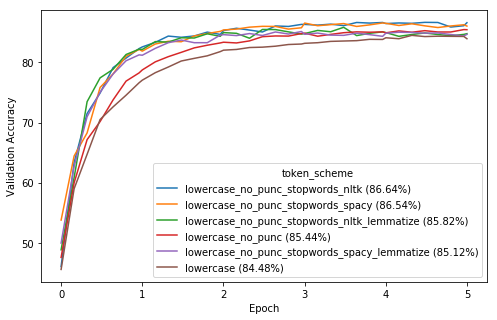

In [443]:
plot_multiple_learning_curves(load_experiment_log(experiment_name='Tokenization_5_epoch'), 'token_scheme')

'lowercase_no_punc_stopwords_nltk' tokenization scheme yields the best performance on our validation set. We shall proceed with this tokenization scheme. 

### Optimization Hyperparameters  

Before we proceed to optimize the model hyperparameters, let's find a set of optimization hyperparameters that allows the model to learn well efficiently so that we can iterate through many combinations of model hyperparameters quickly after. 

In terms of optimization hyperparameters, we need to make decisions on: base optimization algorithm, learning rate, as well as whether linear annealing of learning rate is performed.  

In [593]:
# default to using the tokenization scheme that won previously 
SELECT_TOKENIZATION_SCHEME = 'lowercase_no_punc_stopwords_nltk'

In [667]:
lr_adj_schedules = {
    'None': {'lr_adj_step':1, 'lr_adj_gamma':1},
    'Gamma0.90_Steps01': {'lr_adj_step':1, 'lr_adj_gamma':0.90},
    'Gamma0.50_Steps01': {'lr_adj_step':1, 'lr_adj_gamma':0.50}} 

In [611]:
algo_choices = ['Adam', 'SGD']
learning_rates = [0.01, 0.005, 0.001, 0.0005]

In [612]:
# try different combos of optimization algo and learning rate (without lr annealing)
train_data_tokens, val_data_tokens, test_data_tokens = load_tokens_from_disk(folder_name=SELECT_TOKENIZATION_SCHEME)

for algo in algo_choices: 
    for lr in learning_rates: 
        print ("Training with {} optimization at lr={}...".format(algo, lr))
        results, hyperparams, runtime = run_experiment(
            train_data_tokens, val_data_tokens, train_labels, val_labels, 
            max_sentence_length=200, max_vocab_size=10000, emb_dim=100, optim_algo=algo, 
            learning_rate=lr, num_epochs=10, batch_size=32, 
            experiment_name='algo_lr_10epochs', token_scheme=SELECT_TOKENIZATION_SCHEME,
            max_ngram='Default', lr_annealing = 'None', 
            save_to_log=True, print_summary=True, print_intermediate=True) 

Training with Adam optimization at lr=0.01...
Epoch: 0.00, Train Accuracy: 50.91%, Validation Accuracy: 50.76%
Epoch: 0.16, Train Accuracy: 85.42%, Validation Accuracy: 83.04%
Epoch: 0.32, Train Accuracy: 89.29%, Validation Accuracy: 85.18%
Epoch: 0.48, Train Accuracy: 90.98%, Validation Accuracy: 85.58%
Epoch: 0.64, Train Accuracy: 92.58%, Validation Accuracy: 85.50%
Epoch: 0.80, Train Accuracy: 93.53%, Validation Accuracy: 84.84%
Epoch: 0.96, Train Accuracy: 94.29%, Validation Accuracy: 85.92%
Epoch: 1.00, Train Accuracy: 94.28%, Validation Accuracy: 86.18%
Epoch: 1.16, Train Accuracy: 94.71%, Validation Accuracy: 85.50%
Epoch: 1.32, Train Accuracy: 94.97%, Validation Accuracy: 85.26%
Epoch: 1.48, Train Accuracy: 95.08%, Validation Accuracy: 85.02%
Epoch: 1.64, Train Accuracy: 95.88%, Validation Accuracy: 83.84%
Epoch: 1.80, Train Accuracy: 96.26%, Validation Accuracy: 82.84%
Epoch: 1.96, Train Accuracy: 96.68%, Validation Accuracy: 83.98%
Epoch: 2.00, Train Accuracy: 96.68%, Validat

Epoch: 7.64, Train Accuracy: 99.78%, Validation Accuracy: 81.84%
Epoch: 7.80, Train Accuracy: 99.89%, Validation Accuracy: 82.08%
Epoch: 7.96, Train Accuracy: 99.89%, Validation Accuracy: 81.94%
Epoch: 8.00, Train Accuracy: 99.90%, Validation Accuracy: 81.74%
Epoch: 8.16, Train Accuracy: 99.91%, Validation Accuracy: 81.90%
Epoch: 8.32, Train Accuracy: 99.91%, Validation Accuracy: 82.08%
Epoch: 8.48, Train Accuracy: 99.88%, Validation Accuracy: 82.32%
Epoch: 8.64, Train Accuracy: 99.93%, Validation Accuracy: 82.04%
Epoch: 8.80, Train Accuracy: 99.91%, Validation Accuracy: 81.12%
Epoch: 8.96, Train Accuracy: 99.96%, Validation Accuracy: 81.34%
Epoch: 9.00, Train Accuracy: 99.95%, Validation Accuracy: 81.38%
Epoch: 9.16, Train Accuracy: 99.93%, Validation Accuracy: 81.22%
Epoch: 9.32, Train Accuracy: 99.94%, Validation Accuracy: 81.84%
Epoch: 9.48, Train Accuracy: 99.96%, Validation Accuracy: 81.82%
Epoch: 9.64, Train Accuracy: 99.96%, Validation Accuracy: 81.46%
Epoch: 9.80, Train Accura

Epoch: 4.96, Train Accuracy: 91.08%, Validation Accuracy: 86.00%
Epoch: 5.00, Train Accuracy: 91.09%, Validation Accuracy: 86.14%
Epoch: 5.16, Train Accuracy: 91.31%, Validation Accuracy: 85.80%
Epoch: 5.32, Train Accuracy: 91.48%, Validation Accuracy: 85.96%
Epoch: 5.48, Train Accuracy: 91.62%, Validation Accuracy: 86.04%
Epoch: 5.64, Train Accuracy: 91.83%, Validation Accuracy: 86.00%
Epoch: 5.80, Train Accuracy: 91.87%, Validation Accuracy: 86.18%
Epoch: 5.96, Train Accuracy: 92.01%, Validation Accuracy: 86.32%
Epoch: 6.00, Train Accuracy: 92.11%, Validation Accuracy: 85.90%
Epoch: 6.16, Train Accuracy: 92.25%, Validation Accuracy: 86.02%
Epoch: 6.32, Train Accuracy: 92.38%, Validation Accuracy: 86.02%
Epoch: 6.48, Train Accuracy: 92.55%, Validation Accuracy: 86.38%
Epoch: 6.64, Train Accuracy: 92.65%, Validation Accuracy: 86.16%
Epoch: 6.80, Train Accuracy: 92.80%, Validation Accuracy: 86.32%
Epoch: 6.96, Train Accuracy: 92.84%, Validation Accuracy: 86.58%
Epoch: 7.00, Train Accura

Epoch: 2.16, Train Accuracy: 60.31%, Validation Accuracy: 59.44%
Epoch: 2.32, Train Accuracy: 60.56%, Validation Accuracy: 60.46%
Epoch: 2.48, Train Accuracy: 60.73%, Validation Accuracy: 60.72%
Epoch: 2.64, Train Accuracy: 60.70%, Validation Accuracy: 61.04%
Epoch: 2.80, Train Accuracy: 61.28%, Validation Accuracy: 60.84%
Epoch: 2.96, Train Accuracy: 61.63%, Validation Accuracy: 61.16%
Epoch: 3.00, Train Accuracy: 61.65%, Validation Accuracy: 61.16%
Epoch: 3.16, Train Accuracy: 61.62%, Validation Accuracy: 61.54%
Epoch: 3.32, Train Accuracy: 61.53%, Validation Accuracy: 61.74%
Epoch: 3.48, Train Accuracy: 61.27%, Validation Accuracy: 62.18%
Epoch: 3.64, Train Accuracy: 62.03%, Validation Accuracy: 62.20%
Epoch: 3.80, Train Accuracy: 62.59%, Validation Accuracy: 62.38%
Epoch: 3.96, Train Accuracy: 62.23%, Validation Accuracy: 61.76%
Epoch: 4.00, Train Accuracy: 62.44%, Validation Accuracy: 62.68%
Epoch: 4.16, Train Accuracy: 62.85%, Validation Accuracy: 62.92%
Epoch: 4.32, Train Accura

Epoch: 9.96, Train Accuracy: 56.91%, Validation Accuracy: 57.78%
Epoch: 10.00, Train Accuracy: 56.88%, Validation Accuracy: 57.76%
Experiment completed in 287 seconds with 57.78% validation accuracy.
Training with SGD optimization at lr=0.0005...
Epoch: 0.00, Train Accuracy: 48.99%, Validation Accuracy: 48.16%
Epoch: 0.16, Train Accuracy: 49.20%, Validation Accuracy: 48.10%
Epoch: 0.32, Train Accuracy: 49.30%, Validation Accuracy: 48.26%
Epoch: 0.48, Train Accuracy: 49.34%, Validation Accuracy: 48.26%
Epoch: 0.64, Train Accuracy: 49.47%, Validation Accuracy: 48.34%
Epoch: 0.80, Train Accuracy: 49.53%, Validation Accuracy: 48.52%
Epoch: 0.96, Train Accuracy: 49.69%, Validation Accuracy: 48.24%
Epoch: 1.00, Train Accuracy: 49.69%, Validation Accuracy: 48.26%
Epoch: 1.16, Train Accuracy: 49.73%, Validation Accuracy: 48.24%
Epoch: 1.32, Train Accuracy: 49.84%, Validation Accuracy: 48.44%
Epoch: 1.48, Train Accuracy: 49.88%, Validation Accuracy: 48.46%
Epoch: 1.64, Train Accuracy: 50.09%, V

In [680]:
optim_experiments = summarize_results(load_experiment_log(experiment_name='algo_lr_10epochs'))
optim_experiments[['optim_algo', 'learning_rate', 'lr_annealing', 'num_epochs', 'runtime', 'val_acc']]

,optim_algo,learning_rate,lr_annealing,num_epochs,runtime,val_acc
3,Adam,0.0005,None,10,329.131708,86.86
2,Adam,0.0010,None,10,679.536532,86.84
1,Adam,0.0050,None,10,379.903223,86.20
0,Adam,0.0100,None,10,366.875785,86.18
4,SGD,0.0100,None,10,284.872826,65.52
5,SGD,0.0050,None,10,285.023815,65.08
6,SGD,0.0010,None,10,287.557231,57.78
7,SGD,0.0005,None,10,302.511940,53.78


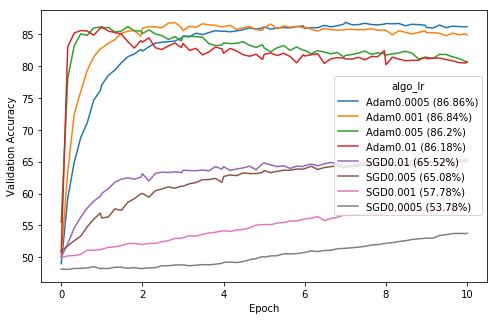

In [646]:
# Adam trains much faster than SGD 
optim_experiments['algo_lr'] = optim_experiments['optim_algo'] + optim_experiments['learning_rate'].astype(str) 
plot_multiple_learning_curves(optim_experiments, 'algo_lr', legend_loc='right')

In [668]:
# try lr annealing on Adam

train_data_tokens, val_data_tokens, test_data_tokens = load_tokens_from_disk(folder_name=SELECT_TOKENIZATION_SCHEME)

for lr in learning_rates: 
    for sched in ['Gamma0.90_Steps01', 'Gamma0.50_Steps01']:  
        print ("Training with Adam optimization at lr={} and sched={}...".format(lr, sched))
        results, hyperparams, runtime = run_experiment(
            train_data_tokens, val_data_tokens, train_labels, val_labels, 
            max_sentence_length=200, max_vocab_size=10000, emb_dim=100, optim_algo='Adam', 
            learning_rate=lr, num_epochs=10, batch_size=32, 
            experiment_name='adam_annealing_10epochs_v4', token_scheme=SELECT_TOKENIZATION_SCHEME,
            max_ngram='Default', lr_annealing = sched, 
            save_to_log=True, print_summary=True, print_intermediate=True) 

Training with Adam optimization at lr=0.01 and sched=Gamma0.90_Steps01...
Epoch: 0.00, Train Accuracy: 50.37%, Validation Accuracy: 48.96%
Epoch: 0.16, Train Accuracy: 85.22%, Validation Accuracy: 83.06%
Epoch: 0.32, Train Accuracy: 89.15%, Validation Accuracy: 85.06%
Epoch: 0.48, Train Accuracy: 90.97%, Validation Accuracy: 84.30%
Epoch: 0.64, Train Accuracy: 92.30%, Validation Accuracy: 84.60%
Epoch: 0.80, Train Accuracy: 93.44%, Validation Accuracy: 85.50%
Epoch: 0.96, Train Accuracy: 94.33%, Validation Accuracy: 85.42%
Epoch: 1.00, Train Accuracy: 94.28%, Validation Accuracy: 84.86%
Epoch: 1.16, Train Accuracy: 94.95%, Validation Accuracy: 85.70%
Epoch: 1.32, Train Accuracy: 95.08%, Validation Accuracy: 85.94%
Epoch: 1.48, Train Accuracy: 95.44%, Validation Accuracy: 84.62%
Epoch: 1.64, Train Accuracy: 95.61%, Validation Accuracy: 85.16%
Epoch: 1.80, Train Accuracy: 96.25%, Validation Accuracy: 84.38%
Epoch: 1.96, Train Accuracy: 96.86%, Validation Accuracy: 84.94%
Epoch: 2.00, Tra

Epoch: 7.48, Train Accuracy: 99.51%, Validation Accuracy: 83.18%
Epoch: 7.64, Train Accuracy: 99.53%, Validation Accuracy: 83.20%
Epoch: 7.80, Train Accuracy: 99.52%, Validation Accuracy: 83.20%
Epoch: 7.96, Train Accuracy: 99.53%, Validation Accuracy: 83.08%
Epoch: 8.00, Train Accuracy: 99.53%, Validation Accuracy: 83.06%
Epoch: 8.16, Train Accuracy: 99.53%, Validation Accuracy: 83.20%
Epoch: 8.32, Train Accuracy: 99.53%, Validation Accuracy: 83.08%
Epoch: 8.48, Train Accuracy: 99.53%, Validation Accuracy: 83.08%
Epoch: 8.64, Train Accuracy: 99.53%, Validation Accuracy: 83.06%
Epoch: 8.80, Train Accuracy: 99.53%, Validation Accuracy: 83.06%
Epoch: 8.96, Train Accuracy: 99.53%, Validation Accuracy: 83.06%
Epoch: 9.00, Train Accuracy: 99.54%, Validation Accuracy: 83.04%
Epoch: 9.16, Train Accuracy: 99.54%, Validation Accuracy: 83.06%
Epoch: 9.32, Train Accuracy: 99.54%, Validation Accuracy: 83.04%
Epoch: 9.48, Train Accuracy: 99.54%, Validation Accuracy: 83.02%
Epoch: 9.64, Train Accura

Epoch: 4.64, Train Accuracy: 98.33%, Validation Accuracy: 84.14%
Epoch: 4.80, Train Accuracy: 98.36%, Validation Accuracy: 84.06%
Epoch: 4.96, Train Accuracy: 98.39%, Validation Accuracy: 84.10%
Epoch: 5.00, Train Accuracy: 98.42%, Validation Accuracy: 84.12%
Epoch: 5.16, Train Accuracy: 98.44%, Validation Accuracy: 84.08%
Epoch: 5.32, Train Accuracy: 98.47%, Validation Accuracy: 84.18%
Epoch: 5.48, Train Accuracy: 98.47%, Validation Accuracy: 84.14%
Epoch: 5.64, Train Accuracy: 98.47%, Validation Accuracy: 84.32%
Epoch: 5.80, Train Accuracy: 98.50%, Validation Accuracy: 84.00%
Epoch: 5.96, Train Accuracy: 98.53%, Validation Accuracy: 83.92%
Epoch: 6.00, Train Accuracy: 98.53%, Validation Accuracy: 83.94%
Epoch: 6.16, Train Accuracy: 98.55%, Validation Accuracy: 83.86%
Epoch: 6.32, Train Accuracy: 98.55%, Validation Accuracy: 83.90%
Epoch: 6.48, Train Accuracy: 98.56%, Validation Accuracy: 83.84%
Epoch: 6.64, Train Accuracy: 98.55%, Validation Accuracy: 83.88%
Epoch: 6.80, Train Accura

Epoch: 1.80, Train Accuracy: 89.05%, Validation Accuracy: 85.16%
Epoch: 1.96, Train Accuracy: 89.67%, Validation Accuracy: 85.40%
Epoch: 2.00, Train Accuracy: 89.55%, Validation Accuracy: 85.70%
Epoch: 2.16, Train Accuracy: 90.02%, Validation Accuracy: 85.48%
Epoch: 2.32, Train Accuracy: 90.19%, Validation Accuracy: 85.54%
Epoch: 2.48, Train Accuracy: 90.43%, Validation Accuracy: 85.76%
Epoch: 2.64, Train Accuracy: 90.64%, Validation Accuracy: 85.76%
Epoch: 2.80, Train Accuracy: 90.80%, Validation Accuracy: 85.66%
Epoch: 2.96, Train Accuracy: 90.97%, Validation Accuracy: 86.28%
Epoch: 3.00, Train Accuracy: 91.07%, Validation Accuracy: 86.20%
Epoch: 3.16, Train Accuracy: 91.16%, Validation Accuracy: 86.04%
Epoch: 3.32, Train Accuracy: 91.30%, Validation Accuracy: 86.10%
Epoch: 3.48, Train Accuracy: 91.38%, Validation Accuracy: 86.04%
Epoch: 3.64, Train Accuracy: 91.47%, Validation Accuracy: 86.14%
Epoch: 3.80, Train Accuracy: 91.50%, Validation Accuracy: 86.00%
Epoch: 3.96, Train Accura

Epoch: 9.32, Train Accuracy: 92.77%, Validation Accuracy: 85.70%
Epoch: 9.48, Train Accuracy: 92.85%, Validation Accuracy: 85.98%
Epoch: 9.64, Train Accuracy: 92.91%, Validation Accuracy: 86.00%
Epoch: 9.80, Train Accuracy: 92.94%, Validation Accuracy: 85.70%
Epoch: 9.96, Train Accuracy: 93.03%, Validation Accuracy: 86.08%
Epoch: 10.00, Train Accuracy: 93.06%, Validation Accuracy: 86.10%
Experiment completed in 368 seconds with 86.1% validation accuracy.
Training with Adam optimization at lr=0.0005 and sched=Gamma0.50_Steps01...
Epoch: 0.00, Train Accuracy: 50.99%, Validation Accuracy: 50.84%
Epoch: 0.16, Train Accuracy: 58.39%, Validation Accuracy: 59.40%
Epoch: 0.32, Train Accuracy: 63.34%, Validation Accuracy: 63.16%
Epoch: 0.48, Train Accuracy: 68.64%, Validation Accuracy: 67.88%
Epoch: 0.64, Train Accuracy: 72.07%, Validation Accuracy: 70.98%
Epoch: 0.80, Train Accuracy: 74.81%, Validation Accuracy: 73.42%
Epoch: 0.96, Train Accuracy: 77.14%, Validation Accuracy: 75.18%
Epoch: 1.0

In [685]:
# combine adam annealing experiments 
adam_annealing = summarize_results(load_experiment_log(experiment_name='adam_annealing_10epochs_v4'))
adam_experiments = pd.concat([adam_annealing, optim_experiments[optim_experiments['optim_algo'] == 'Adam']], axis=0)
adam_experiments[['optim_algo', 'learning_rate', 'lr_annealing', 'num_epochs', 'runtime', 'val_acc']]

,optim_algo,learning_rate,lr_annealing,num_epochs,runtime,val_acc
2,Adam,0.0050,Gamma0.90_Steps01,10,308.435193,86.64
4,Adam,0.0010,Gamma0.90_Steps01,10,354.897561,86.40
5,Adam,0.0010,Gamma0.50_Steps01,10,351.572733,86.28
6,Adam,0.0005,Gamma0.90_Steps01,10,368.178687,86.10
0,Adam,0.0100,Gamma0.90_Steps01,10,331.353019,85.94
1,Adam,0.0100,Gamma0.50_Steps01,10,322.113136,85.92
3,Adam,0.0050,Gamma0.50_Steps01,10,312.008477,85.90
7,Adam,0.0005,Gamma0.50_Steps01,10,336.818504,83.98
3,Adam,0.0005,None,10,329.131708,86.86
2,Adam,0.0010,None,10,679.536532,86.84


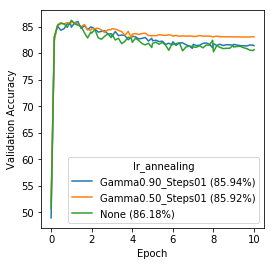

In [696]:
# plot each learning rate as a separate chart 
plot_multiple_learning_curves(adam_experiments[adam_experiments['learning_rate'] == 0.01], 
                              'lr_annealing', figsize=(4,4))

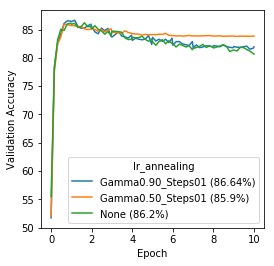

In [697]:
# plot each learning rate as a separate chart 
plot_multiple_learning_curves(adam_experiments[adam_experiments['learning_rate'] == 0.005], 
                              'lr_annealing', figsize=(4,4))

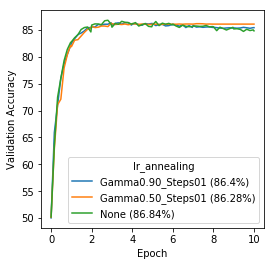

In [698]:
# plot each learning rate as a separate chart 
plot_multiple_learning_curves(adam_experiments[adam_experiments['learning_rate'] == 0.001], 
                              'lr_annealing', figsize=(4,4))

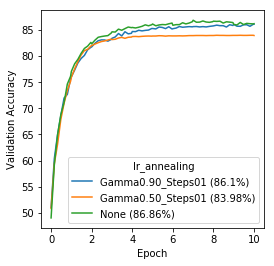

In [699]:
# plot each learning rate as a separate chart 
plot_multiple_learning_curves(adam_experiments[adam_experiments['learning_rate'] == 0.0005], 
                              'lr_annealing', figsize=(4,4))

### Model Hyperparameters

In this section we test various combinations of model hyperparameters, namely max_sentence_length, max_ngram, max_vocab_size, emb_dim. 

#### Embedding Dimensions 

In [647]:
emb_dims = [50, 100, 200, 500, 1000]

In [648]:
# load tokens from selected tokenization scheme 
train_data_tokens, val_data_tokens, test_data_tokens = load_tokens_from_disk(folder_name=SELECT_TOKENIZATION_SCHEME)

for emb_dim in emb_dims: 
    print ("Training with emb_dim = {} ...".format(emb_dim))
    
    # train and evaluate
    results, hyperparams, runtime = run_experiment(
        train_data_tokens, val_data_tokens, train_labels, val_labels, 
        max_sentence_length=200, max_vocab_size=10000, emb_dim=emb_dim, optim_algo='Adam', 
        learning_rate=0.001, num_epochs=5, batch_size=32, 
        experiment_name='Embedding_Dimension_50_1000', token_scheme=SELECT_TOKENIZATION_SCHEME,
        max_ngram='Default', lr_annealing = 'None', 
        save_to_log=True, print_summary=True, print_intermediate=True) 

Training with emb_dim = 50 ...
Epoch: 0.00, Train Accuracy: 49.09%, Validation Accuracy: 46.14%
Epoch: 0.16, Train Accuracy: 61.38%, Validation Accuracy: 58.84%
Epoch: 0.32, Train Accuracy: 64.41%, Validation Accuracy: 63.92%
Epoch: 0.48, Train Accuracy: 72.41%, Validation Accuracy: 70.86%
Epoch: 0.64, Train Accuracy: 77.19%, Validation Accuracy: 74.62%
Epoch: 0.80, Train Accuracy: 80.25%, Validation Accuracy: 77.24%
Epoch: 0.96, Train Accuracy: 82.70%, Validation Accuracy: 79.08%
Epoch: 1.00, Train Accuracy: 83.11%, Validation Accuracy: 79.34%
Epoch: 1.16, Train Accuracy: 84.19%, Validation Accuracy: 80.92%
Epoch: 1.32, Train Accuracy: 85.31%, Validation Accuracy: 81.70%
Epoch: 1.48, Train Accuracy: 86.21%, Validation Accuracy: 82.08%
Epoch: 1.64, Train Accuracy: 86.92%, Validation Accuracy: 83.20%
Epoch: 1.80, Train Accuracy: 87.50%, Validation Accuracy: 84.20%
Epoch: 1.96, Train Accuracy: 88.02%, Validation Accuracy: 84.68%
Epoch: 2.00, Train Accuracy: 88.06%, Validation Accuracy: 8

Epoch: 1.96, Train Accuracy: 92.87%, Validation Accuracy: 86.54%
Epoch: 2.00, Train Accuracy: 92.98%, Validation Accuracy: 86.44%
Epoch: 2.16, Train Accuracy: 92.93%, Validation Accuracy: 85.08%
Epoch: 2.32, Train Accuracy: 93.22%, Validation Accuracy: 85.38%
Epoch: 2.48, Train Accuracy: 93.93%, Validation Accuracy: 86.42%
Epoch: 2.64, Train Accuracy: 94.31%, Validation Accuracy: 86.54%
Epoch: 2.80, Train Accuracy: 94.59%, Validation Accuracy: 86.10%
Epoch: 2.96, Train Accuracy: 94.86%, Validation Accuracy: 86.06%
Epoch: 3.00, Train Accuracy: 94.92%, Validation Accuracy: 85.94%
Epoch: 3.16, Train Accuracy: 95.08%, Validation Accuracy: 86.02%
Epoch: 3.32, Train Accuracy: 95.17%, Validation Accuracy: 85.76%
Epoch: 3.48, Train Accuracy: 95.39%, Validation Accuracy: 85.72%
Epoch: 3.64, Train Accuracy: 95.72%, Validation Accuracy: 85.82%
Epoch: 3.80, Train Accuracy: 96.06%, Validation Accuracy: 85.88%
Epoch: 3.96, Train Accuracy: 96.08%, Validation Accuracy: 86.18%
Epoch: 4.00, Train Accura

In [653]:
embedding_experiments = summarize_results(load_experiment_log(experiment_name='Embedding_Dimension_50_1000'))
embedding_experiments[['emb_dim', 'learning_rate', 'lr_annealing', 'num_epochs', 'runtime', 'val_acc']]

,emb_dim,learning_rate,lr_annealing,num_epochs,runtime,val_acc
3,500,0.001,None,5,579.481342,86.82
2,200,0.001,None,5,313.268762,86.66
4,1000,0.001,None,5,1047.550742,86.52
1,100,0.001,None,5,169.434097,86.50
0,50,0.001,None,5,145.956530,86.46


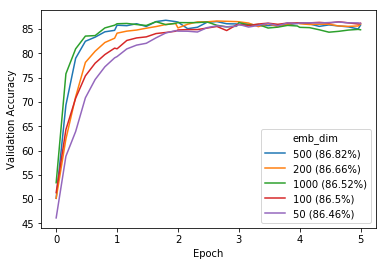

In [709]:
plot_multiple_learning_curves(embedding_experiments, 'emb_dim', figsize=(6,4))

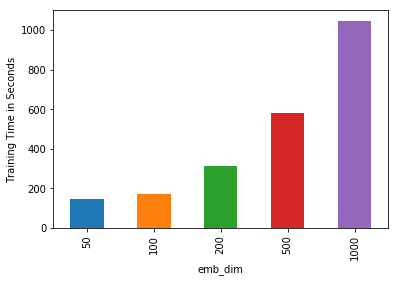

In [710]:
embedding_experiments.set_index('emb_dim').sort_index()['runtime'].plot(kind='bar')
plt.ylabel('Training Time in Seconds');

#### Max Sentence Length

count    20000.000000
mean       129.960400
std         98.413781
min          4.000000
25%         69.000000
50%         96.000000
75%        158.000000
max       1486.000000
dtype: float64


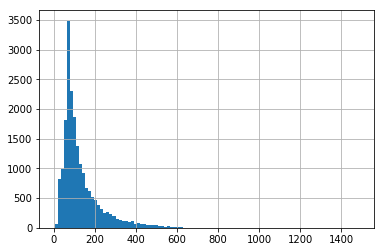

In [717]:
sentence_lengths = pd.Series([len(x) for x in train_data_tokens])
print(sentence_lengths.describe())
sentence_lengths.hist(bins=100);

In [464]:
max_sentence_lengths = [100, 200, 400, 600, 800, 1000, 1500]

In [466]:
# load tokens from selected tokenization scheme 
train_data_tokens, val_data_tokens, test_data_tokens = load_tokens_from_disk(folder_name=SELECT_TOKENIZATION_SCHEME)

for length in max_sentence_lengths: 
    print ("Training with max_sentence_length = {} ...".format(length))
    
    # train and evaluate
    results, hyperparams, runtime = run_experiment(
        train_data_tokens, val_data_tokens, train_labels, val_labels, max_sentence_length=length, max_vocab_size=10000, 
        emb_dim=200, optim_algo='Adam', learning_rate=0.001, num_epochs=5, batch_size=32, token_scheme=t_scheme, 
        experiment_name='Sentence_Lengths_200_1500', save_to_log=True, print_summary=True, print_intermediate=True) 

Training with max_sentence_length = 100 ...
Epoch: 0.00, Train Accuracy: 50.03%, Validation Accuracy: 49.96%
Epoch: 0.16, Train Accuracy: 66.26%, Validation Accuracy: 64.88%
Epoch: 0.32, Train Accuracy: 73.78%, Validation Accuracy: 72.60%
Epoch: 0.48, Train Accuracy: 79.58%, Validation Accuracy: 77.16%
Epoch: 0.64, Train Accuracy: 82.66%, Validation Accuracy: 79.46%
Epoch: 0.80, Train Accuracy: 84.25%, Validation Accuracy: 80.52%
Epoch: 0.96, Train Accuracy: 85.64%, Validation Accuracy: 81.60%
Epoch: 1.00, Train Accuracy: 85.75%, Validation Accuracy: 80.56%
Epoch: 1.16, Train Accuracy: 86.50%, Validation Accuracy: 82.02%
Epoch: 1.32, Train Accuracy: 87.30%, Validation Accuracy: 82.22%
Epoch: 1.48, Train Accuracy: 87.88%, Validation Accuracy: 81.78%
Epoch: 1.64, Train Accuracy: 88.77%, Validation Accuracy: 82.60%
Epoch: 1.80, Train Accuracy: 89.20%, Validation Accuracy: 83.04%
Epoch: 1.96, Train Accuracy: 89.75%, Validation Accuracy: 83.18%
Epoch: 2.00, Train Accuracy: 90.01%, Validatio

Epoch: 1.96, Train Accuracy: 91.55%, Validation Accuracy: 86.50%
Epoch: 2.00, Train Accuracy: 91.66%, Validation Accuracy: 86.38%
Epoch: 2.16, Train Accuracy: 92.08%, Validation Accuracy: 86.72%
Epoch: 2.32, Train Accuracy: 92.37%, Validation Accuracy: 86.24%
Epoch: 2.48, Train Accuracy: 92.65%, Validation Accuracy: 86.92%
Epoch: 2.64, Train Accuracy: 92.83%, Validation Accuracy: 87.24%
Epoch: 2.80, Train Accuracy: 93.22%, Validation Accuracy: 87.18%
Epoch: 2.96, Train Accuracy: 93.44%, Validation Accuracy: 87.60%
Epoch: 3.00, Train Accuracy: 93.55%, Validation Accuracy: 87.28%
Epoch: 3.16, Train Accuracy: 93.68%, Validation Accuracy: 86.86%
Epoch: 3.32, Train Accuracy: 94.01%, Validation Accuracy: 86.96%
Epoch: 3.48, Train Accuracy: 94.28%, Validation Accuracy: 87.50%
Epoch: 3.64, Train Accuracy: 94.39%, Validation Accuracy: 86.50%
Epoch: 3.80, Train Accuracy: 94.75%, Validation Accuracy: 87.24%
Epoch: 3.96, Train Accuracy: 95.00%, Validation Accuracy: 87.00%
Epoch: 4.00, Train Accura

Epoch: 3.80, Train Accuracy: 94.72%, Validation Accuracy: 86.94%
Epoch: 3.96, Train Accuracy: 95.01%, Validation Accuracy: 86.94%
Epoch: 4.00, Train Accuracy: 95.04%, Validation Accuracy: 86.64%
Epoch: 4.16, Train Accuracy: 95.14%, Validation Accuracy: 86.14%
Epoch: 4.32, Train Accuracy: 95.28%, Validation Accuracy: 86.24%
Epoch: 4.48, Train Accuracy: 95.50%, Validation Accuracy: 87.10%
Epoch: 4.64, Train Accuracy: 95.63%, Validation Accuracy: 86.70%
Epoch: 4.80, Train Accuracy: 95.89%, Validation Accuracy: 86.82%
Epoch: 4.96, Train Accuracy: 96.00%, Validation Accuracy: 86.22%
Epoch: 5.00, Train Accuracy: 96.04%, Validation Accuracy: 86.32%
Experiment completed in 909 seconds with 87.1% validation accuracy.


In [467]:
sentence_length_experiments = summarize_results(
    load_experiment_log(experiment_name='Sentence_Lengths_200_1500'),
    exclude_cols=['experiment_name', 'token_scheme', 'results', 'hyperparams'])
sentence_length_experiments

,num_epochs,runtime,max_sentence_length,max_vocab_size,emb_dim,optim_algo,learning_rate,val_acc
3,5,483.084530,600,10000,200,Adam,0.001,87.60
5,5,645.323125,1000,10000,200,Adam,0.001,87.38
2,5,406.658111,400,10000,200,Adam,0.001,87.20
4,5,585.555781,800,10000,200,Adam,0.001,87.20
6,5,909.702732,1500,10000,200,Adam,0.001,87.10
1,5,282.139099,200,10000,200,Adam,0.001,86.36
0,5,186.244781,100,10000,200,Adam,0.001,83.58


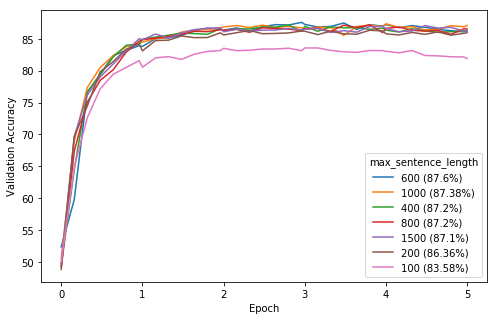

In [468]:
plot_multiple_learning_curves(
    load_experiment_log(experiment_name='Sentence_Lengths_200_1500'), 'max_sentence_length')

#### N-grams

In [718]:
def ngramify_datum(datum_tokens, max_ngram): 
    """ Generates n-grams up to max_ngram for one given list of tokens representing a datum """
    result = [] 
    n = 1
    
    # increment n to append ngrams until n=max_ngram
    while n <= max_ngram: 
        n_grams = [" ".join(item) for item in list(zip(*[datum_tokens[i:] for i in range(n)]))]
        result = result + n_grams 
        n = n + 1 
    
    return result 

In [719]:
def load_and_ngramify_dataset(tokenization_scheme, max_ngram): 
    """ Loads train/val/test 1-gram tokens from disk for a given tokenization scheme, 
        returns the ngrammified dataset """ 
    
    # load unigram tokens from disk 
    train_data_tokens, val_data_tokens, test_data_tokens = load_tokens_from_disk(folder_name=tokenization_scheme)
    
    # ngrammify 
    train_ngrams = [ngramify_datum(datum, max_ngram) for datum in train_data_tokens]  
    val_ngrams = [ngramify_datum(datum, max_ngram) for datum in val_data_tokens] 
    test_ngrams = [ngramify_datum(datum, max_ngram) for datum in test_data_tokens]  
    
    return train_ngrams, val_ngrams, test_ngrams

In [722]:
max_ngrams = [1, 2, 3, 4] 
max_vocab_sizes = [5000, 10000, 15000, 20000, 25000] 

In [723]:
for max_ngram in max_ngrams:
    
    # load and ngramify tokens from selected tokenization scheme 
    train_ngrams, val_ngrams, _ = load_and_ngramify_dataset(SELECT_TOKENIZATION_SCHEME, 
                                                            max_ngram)

    for max_vocab_size in max_vocab_sizes: 
            print ("""Training with max_ngram = {} and max_vocab_size = {}...""".format(
                max_ngram, max_vocab_size))

            # train and evaluate
            results, hyperparams, runtime = run_experiment(
                train_data_tokens, val_data_tokens, train_labels, val_labels, 
                max_sentence_length=600*max_ngram, max_vocab_size=max_vocab_size, 
                max_ngram = max_ngram, emb_dim=200, optim_algo='Adam', learning_rate=0.001,
                lr_annealing = 'None', num_epochs=5, batch_size=32, 
                token_scheme=SELECT_TOKENIZATION_SCHEME, 
                experiment_name='ngram_vocab_5K_25K', save_to_log=True, 
                print_summary=True, print_intermediate=True)

Training with max_ngram = 1 and max_vocab_size = 5000...
Epoch: 0.00, Train Accuracy: 49.30%, Validation Accuracy: 50.22%
Epoch: 0.16, Train Accuracy: 65.06%, Validation Accuracy: 65.94%
Epoch: 0.32, Train Accuracy: 75.47%, Validation Accuracy: 74.76%
Epoch: 0.48, Train Accuracy: 79.83%, Validation Accuracy: 78.94%
Epoch: 0.64, Train Accuracy: 82.20%, Validation Accuracy: 80.68%
Epoch: 0.80, Train Accuracy: 83.62%, Validation Accuracy: 80.86%
Epoch: 0.96, Train Accuracy: 86.51%, Validation Accuracy: 84.38%
Epoch: 1.00, Train Accuracy: 85.78%, Validation Accuracy: 83.96%
Epoch: 1.16, Train Accuracy: 87.31%, Validation Accuracy: 85.04%
Epoch: 1.32, Train Accuracy: 87.92%, Validation Accuracy: 85.46%
Epoch: 1.48, Train Accuracy: 88.58%, Validation Accuracy: 85.56%
Epoch: 1.64, Train Accuracy: 89.08%, Validation Accuracy: 85.76%
Epoch: 1.80, Train Accuracy: 89.46%, Validation Accuracy: 85.76%
Epoch: 1.96, Train Accuracy: 89.73%, Validation Accuracy: 86.32%
Epoch: 2.00, Train Accuracy: 89.8

Epoch: 1.80, Train Accuracy: 92.38%, Validation Accuracy: 86.10%
Epoch: 1.96, Train Accuracy: 92.87%, Validation Accuracy: 86.46%
Epoch: 2.00, Train Accuracy: 93.03%, Validation Accuracy: 86.20%
Epoch: 2.16, Train Accuracy: 93.47%, Validation Accuracy: 86.44%
Epoch: 2.32, Train Accuracy: 93.80%, Validation Accuracy: 86.60%
Epoch: 2.48, Train Accuracy: 94.13%, Validation Accuracy: 86.06%
Epoch: 2.64, Train Accuracy: 94.55%, Validation Accuracy: 86.06%
Epoch: 2.80, Train Accuracy: 94.74%, Validation Accuracy: 86.76%
Epoch: 2.96, Train Accuracy: 95.24%, Validation Accuracy: 86.28%
Epoch: 3.00, Train Accuracy: 95.33%, Validation Accuracy: 86.58%
Epoch: 3.16, Train Accuracy: 95.61%, Validation Accuracy: 86.90%
Epoch: 3.32, Train Accuracy: 95.80%, Validation Accuracy: 86.00%
Epoch: 3.48, Train Accuracy: 96.00%, Validation Accuracy: 86.28%
Epoch: 3.64, Train Accuracy: 96.37%, Validation Accuracy: 86.30%
Epoch: 3.80, Train Accuracy: 96.56%, Validation Accuracy: 85.60%
Epoch: 3.96, Train Accura

Epoch: 3.64, Train Accuracy: 94.47%, Validation Accuracy: 87.26%
Epoch: 3.80, Train Accuracy: 94.68%, Validation Accuracy: 87.26%
Epoch: 3.96, Train Accuracy: 94.93%, Validation Accuracy: 87.08%
Epoch: 4.00, Train Accuracy: 94.99%, Validation Accuracy: 87.16%
Epoch: 4.16, Train Accuracy: 95.13%, Validation Accuracy: 87.04%
Epoch: 4.32, Train Accuracy: 95.39%, Validation Accuracy: 86.70%
Epoch: 4.48, Train Accuracy: 95.42%, Validation Accuracy: 86.40%
Epoch: 4.64, Train Accuracy: 95.61%, Validation Accuracy: 86.98%
Epoch: 4.80, Train Accuracy: 95.83%, Validation Accuracy: 86.80%
Epoch: 4.96, Train Accuracy: 96.09%, Validation Accuracy: 86.66%
Epoch: 5.00, Train Accuracy: 95.84%, Validation Accuracy: 86.92%
Experiment completed in 786 seconds with 87.32% validation accuracy.
Training with max_ngram = 2 and max_vocab_size = 15000...
Epoch: 0.00, Train Accuracy: 54.28%, Validation Accuracy: 54.72%
Epoch: 0.16, Train Accuracy: 71.84%, Validation Accuracy: 70.20%
Epoch: 0.32, Train Accuracy:

Epoch: 0.00, Train Accuracy: 49.50%, Validation Accuracy: 49.32%
Epoch: 0.16, Train Accuracy: 64.05%, Validation Accuracy: 63.56%
Epoch: 0.32, Train Accuracy: 76.69%, Validation Accuracy: 74.88%
Epoch: 0.48, Train Accuracy: 80.72%, Validation Accuracy: 78.64%
Epoch: 0.64, Train Accuracy: 82.30%, Validation Accuracy: 80.80%
Epoch: 0.80, Train Accuracy: 84.34%, Validation Accuracy: 82.50%
Epoch: 0.96, Train Accuracy: 86.44%, Validation Accuracy: 83.86%
Epoch: 1.00, Train Accuracy: 86.68%, Validation Accuracy: 84.04%
Epoch: 1.16, Train Accuracy: 86.66%, Validation Accuracy: 84.66%
Epoch: 1.32, Train Accuracy: 87.77%, Validation Accuracy: 85.12%
Epoch: 1.48, Train Accuracy: 88.27%, Validation Accuracy: 85.12%
Epoch: 1.64, Train Accuracy: 88.98%, Validation Accuracy: 85.56%
Epoch: 1.80, Train Accuracy: 89.42%, Validation Accuracy: 86.02%
Epoch: 1.96, Train Accuracy: 89.77%, Validation Accuracy: 85.92%
Epoch: 2.00, Train Accuracy: 89.69%, Validation Accuracy: 86.24%
Epoch: 2.16, Train Accura

Epoch: 1.96, Train Accuracy: 92.83%, Validation Accuracy: 86.34%
Epoch: 2.00, Train Accuracy: 92.95%, Validation Accuracy: 86.52%
Epoch: 2.16, Train Accuracy: 93.30%, Validation Accuracy: 86.94%
Epoch: 2.32, Train Accuracy: 93.81%, Validation Accuracy: 86.84%
Epoch: 2.48, Train Accuracy: 94.11%, Validation Accuracy: 86.84%
Epoch: 2.64, Train Accuracy: 94.48%, Validation Accuracy: 86.92%
Epoch: 2.80, Train Accuracy: 94.69%, Validation Accuracy: 86.38%
Epoch: 2.96, Train Accuracy: 95.05%, Validation Accuracy: 85.82%
Epoch: 3.00, Train Accuracy: 95.42%, Validation Accuracy: 86.48%
Epoch: 3.16, Train Accuracy: 95.62%, Validation Accuracy: 86.62%
Epoch: 3.32, Train Accuracy: 95.85%, Validation Accuracy: 86.72%
Epoch: 3.48, Train Accuracy: 96.11%, Validation Accuracy: 86.76%
Epoch: 3.64, Train Accuracy: 96.34%, Validation Accuracy: 86.78%
Epoch: 3.80, Train Accuracy: 96.80%, Validation Accuracy: 86.36%
Epoch: 3.96, Train Accuracy: 97.03%, Validation Accuracy: 86.56%
Epoch: 4.00, Train Accura

Epoch: 3.80, Train Accuracy: 94.78%, Validation Accuracy: 86.50%
Epoch: 3.96, Train Accuracy: 94.89%, Validation Accuracy: 86.78%
Epoch: 4.00, Train Accuracy: 95.03%, Validation Accuracy: 86.80%
Epoch: 4.16, Train Accuracy: 95.22%, Validation Accuracy: 86.92%
Epoch: 4.32, Train Accuracy: 95.35%, Validation Accuracy: 86.98%
Epoch: 4.48, Train Accuracy: 95.61%, Validation Accuracy: 86.16%
Epoch: 4.64, Train Accuracy: 95.83%, Validation Accuracy: 86.84%
Epoch: 4.80, Train Accuracy: 96.03%, Validation Accuracy: 86.86%
Epoch: 4.96, Train Accuracy: 96.14%, Validation Accuracy: 86.24%
Epoch: 5.00, Train Accuracy: 96.22%, Validation Accuracy: 86.22%
Experiment completed in 1506 seconds with 87.02% validation accuracy.
Training with max_ngram = 4 and max_vocab_size = 15000...
Epoch: 0.00, Train Accuracy: 49.94%, Validation Accuracy: 52.00%
Epoch: 0.16, Train Accuracy: 71.52%, Validation Accuracy: 71.28%
Epoch: 0.32, Train Accuracy: 78.41%, Validation Accuracy: 76.14%
Epoch: 0.48, Train Accuracy

In [514]:
ngram_vocab_sentlens_600 = summarize_results(
    load_experiment_log(experiment_name='ngram_vocab_sentlens_600_100emb_2epoch_lr005'),
    exclude_cols=['experiment_name', 'token_scheme', 'results', 'hyperparams'])
ngram_vocab_sentlens_600

,num_epochs,runtime,max_sentence_length,max_vocab_size,emb_dim,optim_algo,learning_rate,val_acc
5,2,83.882795,600,5000,100,Adam,0.005,87.26
10,2,92.335143,600,5000,100,Adam,0.005,87.24
1,2,91.530360,600,10000,100,Adam,0.005,87.16
6,2,116.739858,600,10000,100,Adam,0.005,87.12
11,2,95.073206,600,10000,100,Adam,0.005,87.10
15,2,111.507432,600,5000,100,Adam,0.005,87.04
2,2,138.236427,600,25000,100,Adam,0.005,87.02
16,2,120.451190,600,10000,100,Adam,0.005,86.94
0,2,82.375202,600,5000,100,Adam,0.005,86.94
13,2,198.626602,600,50000,100,Adam,0.005,86.90


In [513]:
for max_ngram in max_ngrams:
    
    # load and ngramify tokens from selected tokenization scheme 
    train_ngrams, val_ngrams, _ = load_and_ngramify_dataset(SELECT_TOKENIZATION_SCHEME, 
                                                            max_ngram)

    for max_vocab_size in max_vocab_sizes: 
        for max_sentence_length in set([600*max_ngram]): 
#        for max_sentence_length in set([600, 600*max_ngram]): 
            print ("""Training with max_ngram = {} and max_vocab_size = {} and 
            max_sentence_length = {}...""".format(
                max_ngram, max_vocab_size, max_sentence_length))

            # train and evaluate
            results, hyperparams, runtime = run_experiment(
                train_data_tokens, val_data_tokens, train_labels, val_labels, 
                max_sentence_length=max_sentence_length, max_vocab_size=max_vocab_size, 
                emb_dim=100, optim_algo='Adam', learning_rate=0.005, num_epochs=2, 
                batch_size=32, token_scheme=SELECT_TOKENIZATION_SCHEME, 
                experiment_name='ngram_vocab_sentlens_600xN_100emb_2epoch_lr005', save_to_log=True, 
                print_summary=True, print_intermediate=True)

Training with max_ngram = 1 and max_vocab_size = 5000 and 
            max_sentence_length = 600...
Epoch: 0.00, Train Accuracy: 50.03%, Validation Accuracy: 49.94%
Epoch: 0.16, Train Accuracy: 80.53%, Validation Accuracy: 80.12%
Epoch: 0.32, Train Accuracy: 86.66%, Validation Accuracy: 84.20%
Epoch: 0.48, Train Accuracy: 88.47%, Validation Accuracy: 85.38%
Epoch: 0.64, Train Accuracy: 89.75%, Validation Accuracy: 86.38%
Epoch: 0.80, Train Accuracy: 90.83%, Validation Accuracy: 86.72%
Epoch: 0.96, Train Accuracy: 91.49%, Validation Accuracy: 87.28%
Epoch: 1.00, Train Accuracy: 91.56%, Validation Accuracy: 86.84%
Epoch: 1.16, Train Accuracy: 92.17%, Validation Accuracy: 87.30%
Epoch: 1.32, Train Accuracy: 92.03%, Validation Accuracy: 85.86%
Epoch: 1.48, Train Accuracy: 92.59%, Validation Accuracy: 87.10%
Epoch: 1.64, Train Accuracy: 93.28%, Validation Accuracy: 86.66%
Epoch: 1.80, Train Accuracy: 93.61%, Validation Accuracy: 86.72%
Epoch: 1.96, Train Accuracy: 93.47%, Validation Accurac

Epoch: 0.32, Train Accuracy: 87.94%, Validation Accuracy: 84.08%
Epoch: 0.48, Train Accuracy: 90.65%, Validation Accuracy: 85.60%
Epoch: 0.64, Train Accuracy: 92.44%, Validation Accuracy: 86.52%
Epoch: 0.80, Train Accuracy: 93.69%, Validation Accuracy: 85.00%
Epoch: 0.96, Train Accuracy: 95.05%, Validation Accuracy: 86.30%
Epoch: 1.00, Train Accuracy: 95.34%, Validation Accuracy: 86.28%
Epoch: 1.16, Train Accuracy: 95.83%, Validation Accuracy: 86.40%
Epoch: 1.32, Train Accuracy: 96.39%, Validation Accuracy: 86.24%
Epoch: 1.48, Train Accuracy: 96.70%, Validation Accuracy: 85.06%
Epoch: 1.64, Train Accuracy: 96.94%, Validation Accuracy: 86.02%
Epoch: 1.80, Train Accuracy: 97.82%, Validation Accuracy: 84.86%
Epoch: 1.96, Train Accuracy: 98.38%, Validation Accuracy: 84.88%
Epoch: 2.00, Train Accuracy: 98.42%, Validation Accuracy: 84.06%
Experiment completed in 253 seconds with 86.52% validation accuracy.
Training with max_ngram = 2 and max_vocab_size = 50000 and 
            max_sentence_l

Epoch: 0.80, Train Accuracy: 94.39%, Validation Accuracy: 86.50%
Epoch: 0.96, Train Accuracy: 95.95%, Validation Accuracy: 86.46%
Epoch: 1.00, Train Accuracy: 96.25%, Validation Accuracy: 86.80%
Epoch: 1.16, Train Accuracy: 96.71%, Validation Accuracy: 85.66%
Epoch: 1.32, Train Accuracy: 97.02%, Validation Accuracy: 86.50%
Epoch: 1.48, Train Accuracy: 97.52%, Validation Accuracy: 86.24%
Epoch: 1.64, Train Accuracy: 97.80%, Validation Accuracy: 84.62%
Epoch: 1.80, Train Accuracy: 98.51%, Validation Accuracy: 84.94%
Epoch: 1.96, Train Accuracy: 99.09%, Validation Accuracy: 84.50%
Epoch: 2.00, Train Accuracy: 99.17%, Validation Accuracy: 84.12%
Experiment completed in 457 seconds with 86.8% validation accuracy.
Training with max_ngram = 4 and max_vocab_size = 5000 and 
            max_sentence_length = 2400...
Epoch: 0.00, Train Accuracy: 48.89%, Validation Accuracy: 48.44%
Epoch: 0.16, Train Accuracy: 78.86%, Validation Accuracy: 77.52%
Epoch: 0.32, Train Accuracy: 84.81%, Validation Acc

In [199]:
# model hyperparameters to try 
max_ngrams = [1, 2, 3, 4] 

# default hyperparameters to use 
EMB_DIM = 100
MAX_VOCAB_SIZE = 10000
LR = 0.001
NUM_EPOCHS = 2 

# max_vocab_sizes = [10000, 50000, 100000, 250000, 500000] 
# emb_dims = [50, 100, 250, 500, 1000]

# max_ngrams = [1, 2] 
# max_vocab_sizes = [250000, 500000] 
# emb_dims = [500, 1000]

In [ ]:
ngrams_experiments = {}
# num_experiments = len(max_ngrams) * len(max_vocab_sizes) * len(emb_dims)

# for max_ngram in max_ngrams:
#     # load and ngramify tokens from selected tokenization scheme 
#     train_ngrams, val_ngrams, _ = load_and_ngramify_dataset(SELECT_TOKENIZATION_SCHEME, max_ngram)

#     for max_vocab_size in max_vocab_sizes: 
#         for emb_dim in emb_dims: 
                  
#             # train and evaluate 
#             results = run_experiment(train_ngrams, val_ngrams, train_labels, val_labels, optimizer=Adam, 
#                                      learning_rate=0.01, emb_dim=emb_dim, max_vocab_size=max_vocab_size, 
#                                      max_sentence_length=200, num_epochs=5, batch_size=32, print_results=False)
            
#             # store to dict and save to pickle 
#             hyparams = str({'max_ngram': max_ngram, 'max_vocab_size': max_vocab_size, 'emb_dim': emb_dim})
#             model_hyparams_experiments[hyparams] = results 

#             # print and report results of each experiment 
#             print("Experiment [{}/{}]: {} completed with {:.1f}% accuracy".format(
#                 len(model_hyparams_experiments), num_experiments, hyparams, 
#                 pd.DataFrame.from_dict(results)['val_acc'].max()))

# # save results to pickle 
# current_dt = datetime.now().strftime('%Y-%m-%d_%H_%M_%S')
# results_filename = 'experiment_results/model_hyperparameter_experiments_{}.csv'.format(current_dt)
# save_to_pickle(model_hyparams_experiments, results_filename) 
# print("Finished: Results saved to {}".format(results_filename))

In [196]:
# run grid search on model hyperparameters 

# model_hyparams_experiments = {}
# num_experiments = len(max_ngrams) * len(max_vocab_sizes) * len(emb_dims)

# for max_ngram in max_ngrams:
#     # load and ngramify tokens from selected tokenization scheme 
#     train_ngrams, val_ngrams, _ = load_and_ngramify_dataset(SELECT_TOKENIZATION_SCHEME, max_ngram)

#     for max_vocab_size in max_vocab_sizes: 
#         for emb_dim in emb_dims: 
                  
#             # train and evaluate 
#             results = run_experiment(train_ngrams, val_ngrams, train_labels, val_labels, optimizer=Adam, 
#                                      learning_rate=0.01, emb_dim=emb_dim, max_vocab_size=max_vocab_size, 
#                                      max_sentence_length=200, num_epochs=5, batch_size=32, print_results=False)
            
#             # store to dict and save to pickle 
#             hyparams = str({'max_ngram': max_ngram, 'max_vocab_size': max_vocab_size, 'emb_dim': emb_dim})
#             model_hyparams_experiments[hyparams] = results 

#             # print and report results of each experiment 
#             print("Experiment [{}/{}]: {} completed with {:.1f}% accuracy".format(
#                 len(model_hyparams_experiments), num_experiments, hyparams, 
#                 pd.DataFrame.from_dict(results)['val_acc'].max()))

# # save results to pickle 
# current_dt = datetime.now().strftime('%Y-%m-%d_%H_%M_%S')
# results_filename = 'experiment_results/model_hyperparameter_experiments_{}.csv'.format(current_dt)
# save_to_pickle(model_hyparams_experiments, results_filename) 
# print("Finished: Results saved to {}".format(results_filename))

Experiment [1/100]: {'max_ngram': 1, 'max_vocab_size': 10000, 'emb_dim': 50} completed with 84.1% accuracy
Experiment [2/100]: {'max_ngram': 1, 'max_vocab_size': 10000, 'emb_dim': 100} completed with 84.2% accuracy
Experiment [3/100]: {'max_ngram': 1, 'max_vocab_size': 10000, 'emb_dim': 250} completed with 83.8% accuracy
Experiment [4/100]: {'max_ngram': 1, 'max_vocab_size': 10000, 'emb_dim': 500} completed with 83.4% accuracy
Experiment [5/100]: {'max_ngram': 1, 'max_vocab_size': 10000, 'emb_dim': 1000} completed with 82.8% accuracy
Experiment [6/100]: {'max_ngram': 1, 'max_vocab_size': 50000, 'emb_dim': 50} completed with 83.5% accuracy
Experiment [7/100]: {'max_ngram': 1, 'max_vocab_size': 50000, 'emb_dim': 100} completed with 83.5% accuracy
Experiment [8/100]: {'max_ngram': 1, 'max_vocab_size': 50000, 'emb_dim': 250} completed with 83.2% accuracy
Experiment [9/100]: {'max_ngram': 1, 'max_vocab_size': 50000, 'emb_dim': 500} completed with 82.8% accuracy
Experiment [10/100]: {'max_ng

KeyboardInterrupt: 

In [176]:
results_filename = 'experiment_results/model_hyperparameter_experiments_2018-10-04_22_42_17.csv'
model_hyparams_experiments = pkl.load(open(results_filename, "rb"))
model_hyparams_val_acc = print_val_accuracy(model_hyparams_experiments, split_name=True)  
model_hyparams_val_acc

,model,max_ngram,max_vocab_size,emb_dim,val_acc
1,"{'max_ngram': 1, 'max_vocab_size': 10000, 'emb_dim': 100}",1,10000,100,84.28
0,"{'max_ngram': 1, 'max_vocab_size': 10000, 'emb_dim': 50}",1,10000,50,84.22
4,"{'max_ngram': 2, 'max_vocab_size': 10000, 'emb_dim': 50}",2,10000,50,84.10
5,"{'max_ngram': 2, 'max_vocab_size': 10000, 'emb_dim': 100}",2,10000,100,84.08
6,"{'max_ngram': 2, 'max_vocab_size': 50000, 'emb_dim': 50}",2,50000,50,83.98
3,"{'max_ngram': 1, 'max_vocab_size': 50000, 'emb_dim': 100}",1,50000,100,83.92
2,"{'max_ngram': 1, 'max_vocab_size': 50000, 'emb_dim': 50}",1,50000,50,83.86
7,"{'max_ngram': 2, 'max_vocab_size': 50000, 'emb_dim': 100}",2,50000,100,83.38


### Optimization Hyperparameters 

In [182]:
optim_algos = {'Adam': Adam, 'SGD': SGD, 'RMSprop': RMSprop}
learning_rates = [0.1, 0.01, 0.001]

EMB_DIM = 100 
MAX_VOCAB_SIZE = 10000 
MAX_NGRAM = 2

In [183]:
train_ngrams, val_ngrams, _ = load_and_ngramify_dataset(SELECT_TOKENIZATION_SCHEME, max_ngram=MAX_NGRAM)

In [184]:
# run grid search on model hyperparameters 

optim_hyparams_experiments = {}
num_experiments = len(optim_algos) * len(learning_rates)

for algo in optim_algos: 
    for lr in learning_rates: 

        # train and evaluate 
        results = run_experiment(train_ngrams, val_ngrams, train_labels, val_labels, optimizer=optim_algos[algo], 
                                 learning_rate=lr, emb_dim=EMB_DIM, max_vocab_size=MAX_VOCAB_SIZE, 
                                 max_sentence_length=200, num_epochs=1, batch_size=32, print_results=False)

        # store to dict and save to pickle 
        hyparams = str({'optim_algo': algo, 'learning_rate': lr})
        optim_hyparams_experiments[hyparams] = results 

        # print and report results of each experiment 
        print("Experiment [{}/{}]: {} completed with {:.1f}% accuracy".format(
            len(optim_hyparams_experiments), num_experiments, hyparams, 
            pd.DataFrame.from_dict(results)['val_acc'].max()))

# save results to pickle 
current_dt = datetime.now().strftime('%Y-%m-%d_%H_%M_%S')
results_filename = 'experiment_results/optim_hyperparameter_experiments_{}.csv'.format(current_dt)
save_to_pickle(optim_hyparams_experiments, results_filename) 
print("Finished: Results saved to {}".format(results_filename))

Experiment [1/9]: {'optim_algo': 'Adam', 'learning_rate': 0.1} completed with 82.1% accuracy
Experiment [2/9]: {'optim_algo': 'Adam', 'learning_rate': 0.01} completed with 84.3% accuracy
Experiment [3/9]: {'optim_algo': 'Adam', 'learning_rate': 0.001} completed with 77.3% accuracy
Experiment [4/9]: {'optim_algo': 'SGD', 'learning_rate': 0.1} completed with 64.2% accuracy
Experiment [5/9]: {'optim_algo': 'SGD', 'learning_rate': 0.01} completed with 58.1% accuracy
Experiment [6/9]: {'optim_algo': 'SGD', 'learning_rate': 0.001} completed with 49.7% accuracy
Experiment [7/9]: {'optim_algo': 'RMSprop', 'learning_rate': 0.1} completed with 83.9% accuracy
Experiment [8/9]: {'optim_algo': 'RMSprop', 'learning_rate': 0.01} completed with 84.0% accuracy
Experiment [9/9]: {'optim_algo': 'RMSprop', 'learning_rate': 0.001} completed with 78.4% accuracy
Finished: Results saved to experiment_results/optim_hyperparameter_experiments_2018-10-04_23_44_23.csv
